<a href="https://colab.research.google.com/github/DomMc97/Classification-Fashion-MNIST/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Fashion MNIST Dataset

A classification of the Fashion MNIST dataset using a Multi Layer Perceptron(MLP) and a Convolution Neural Network (CNN).

This dataset is a collection of images of fashion items sold by Zalando. Each sample is originally a grayscale image with 28x28 pixels. Each pixel has a value of the grayscale between 0 and 255. The images will be described as p-dimensional vectors $(p=28^{2}=784)$ for the MLP and as a 28x28 matrices for the CNN.

Each image in the dataset belongs to one of $C=10$ classes with the following labels: 

![](https://drive.google.com/uc?id=1EAGP0AjyptOy7uON_Gr578XyLHc1M0SA)

The dataset consists of 60000 images in the training set and 10000 additional images.



---

## Set up

In [1]:
# scientific library
import numpy as np

# data analytics library
import pandas as pd

# sklearn functions
#from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# pytorch functions
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets design of figures

# libraries for saving/loading data
import pickle
from google.colab import drive

In [2]:
%%capture
# installs skorch for
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch

from skorch import NeuralNetClassifier
from skorch.callbacks import Callback

Mount Google Drive

In [3]:
# mount drive
drive.mount('/content/drive', force_remount=True)

# root of all file paths used in notebook
root = '/content/drive/My Drive/Methods for Data Science/CW3/Fashion/'

Mounted at /content/drive



Asks user whether this is the first run of the code to avoid repeat computations.

In [4]:
# code reapeats until a valid input is inserted for the question.
while True:
    init_run = input('Is this the first run of the code y/n?\n')

    if init_run == 'y':
        init_run = True
        break
    elif init_run == 'n':
        init_run = False
        break
    else:
        print('Invalid input.\n')

Is this the first run of the code y/n?
n


An importation of the dataset of images using sklearn  (where the images are represented as 784-dimensional vectors) and then split into the test and train set. The dataset is ordered such that the first 60,000 images are the training set and the rest are the test set. 

In [5]:
# downloads data
mnist = fetch_openml('Fashion-MNIST', cache=False)

# images
X = mnist.data.astype('float32')
# ground truth labels
y = mnist.target.astype('int64')

# test train split
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

A function which scores the performance of a model.

In [6]:
def performance(pred, y):
    """A function which returns the performance metrics of a classification 
    predictions of a given pretrained model on a test set.
    Inputs:
        pred: Predictions of a trained classifier.
        y: The labels of a test/trainig set.
      Outputs:
          acc: The accuracy of a prediction.
          rec: The recall of a prediction.
          pre: The precision of a prediction.
          F1: The F1 score of a prediction.
          mat: The confsusion matrix of a prediction.
    """ 
    # performance metrics
    acc = metrics.accuracy_score(y, pred)*100
    rec = metrics.recall_score(y, pred, average='macro')
    pre = metrics.precision_score(y, pred, average='macro')
    F1 = metrics.f1_score(y, pred, average='macro')
    mat = metrics.confusion_matrix(y, pred)

    # prints results
    print('##################################')
    print('Performance Metrics for Prediction')
    print('##################################\n')
    print('The accuracy is %.1f'%acc + '%')
    print('The recall is %.3f.'%rec)
    print('The precision is %.3f.'%pre)
    print('The F1 score is %.3f.'%F1)

    # plots confusion matrix
    fig = plt.figure(figsize=(12,7))
    title ='Confusion Matrix'
    cmat = pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted'])
    plt.title(title, fontsize='15')
    sns.heatmap(cmat, annot=True, fmt='.0f')
    plt.show()

    return acc, rec, pre, F1, mat

## MLP Neural Network Supervised Classification

Using PyTorch, I will implement a multilayer perceptron
(MLP) to classify the images of the dataset into the 10 classes.

<u>Setup of Network</u>

My MLP will have a number of input nodes equal to the number of pixels in each image, three hidden layers, each with 100 nodes, and an output layer with 10 nodes corresponding to the number of classes. I will use ReLU as my activation function with no dropout. 

For the training, I will use a negative log-likelihood loss, a learning rate of 0.005, and stochastic gradient descent (SGD) as the optimisation method. I will train in batches of 128 images for 30 epochs.


### Model Initialisation

Defining of input parameters

In [7]:
# defining hyperparameters
input_size = 784 # 28x28
hidden_size = 100
num_classes = 10
num_epochs = 30
batch_size = 128
learning_rate = 0.005

I'll now initialise the MLP.

In [8]:
class MLP(nn.Module):
  # define fully connected matrices in between layers
  def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.W1 = nn.Linear(input_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.W3 = nn.Linear(hidden_size, hidden_size)
        self.W4 = nn.Linear(hidden_size, num_classes)
  
  # forward pass through network with relu function
  def forward(self, x):
        out = F.relu(self.W1(x))
        out = F.relu(self.W2(out))
        out = F.relu(self.W3(out))
        out = self.W4(out)
        out = F.softmax(out, dim=-1)
        return out

# apply skorch wrapper to Network for use with sklearn
MLP_net = NeuralNetClassifier(
    MLP(input_size, hidden_size, num_classes),
    max_epochs=num_epochs,
    batch_size=batch_size,
    criterion = nn.NLLLoss,
    optimizer = SGD,
    optimizer__lr=learning_rate
    )

### Training of Model

I'll now train the model.

In [9]:
%%time
# if initial run train and save the model
if init_run:
    # trains model
    MLP_net.fit(X_train, y_train)

    # save results
    with open(root + 'MLP_net.sav', 'wb') as fp:
        pickle.dump(MLP_net, fp)

# else load the trained model
else:
    MLP_net = pickle.load(open(root + 'MLP_net.sav', 'rb'))

CPU times: user 14.9 ms, sys: 53 µs, total: 15 ms
Wall time: 1.72 s


### Accuracy of the Model

I'll make predictions on the test set to determine the quality of the classifier.

##################################
Performance Metrics for Prediction
##################################

The accuracy is 86.7%
The recall is 0.867.
The precision is 0.868.
The F1 score is 0.865.


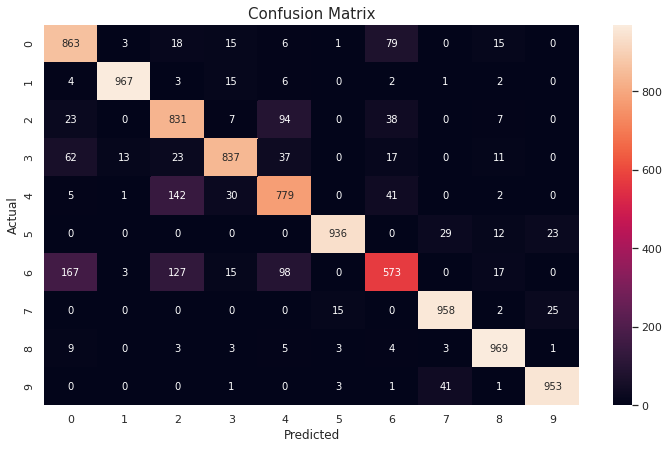

In [10]:
# if the initial run make and save predictios
if init_run:
    pred = MLP_net.predict(X_test)
    with open(root + 'MLP_pred.sav', 'wb') as fp:
        pickle.dump(pred, fp)
# else load predictions
else:
    pred = pickle.load(open(root + 'MLP_pred.sav', 'rb'))

# performance of the MLP
MLP_performance = performance(pred, y_test)

## Convolutional Neural Network (CNN) Supervised Classification

Now using PyTorch, I'll build a small CNN
to classify the images of the dataset into the 10 classes.

<u>Setup of network</u>

My CNN will have the following architecture,

![CNN](https://drive.google.com/uc?id=1SuSTQeqi-Q3_y0rb2rNJustMtsJ-RmqX)

I will choose ReLU as the activation functions, reduce the dimensionality of the feature maps by a subsampling layer where the highest value in each subsampled feature map is chosen, implement a stride of 2 into these pooling layers, and have a kernel size of 5 in all convolutional layers. The stride and the dilation in the convolutional layers will be both 1.


**CNN:**

A Convolution Neural Network (CNN) is a type of Neural Network which allows us to pass the image through as a tensor instead of vectorised image allowing us to conserve the spatial relationship between pixels.

The 4 main steps for CNN classification are:



1.   Convolution-apply convolutional filters
2.   Non-linear function
3.   Pooling operation – reduce matrix size
4.   Fully connected MLP

**Convolutional Filter:**

A convolutional filter is a filter matching the dimension of the image it is applied too (i.e a 2D filter would be applied to a 2D image) which pans across an image converting the values covered by the filter at each step to a single value.

For example we could apply a convolution with a kernel size of 3, meaning a ($3 \times 3$) filter, to a ($4 \times 4$) image.

![](https://miro.medium.com/max/1050/1*GuVRt1T9apScnlA6DLvbZA.png)

Each value in the output image is the result of a matrix multiplication between the values of the image within the filter window and the values of the filter.

![](https://miro.medium.com/max/1050/1*gqDdVjiBDKbfiy73Dla4GQ.png)

The filter window shifts along the columns of the image in steps of size determined by the stride parameter, which is 1 in this case, until the window meets the end of a column. The window will then shift down the rows an amount of rows according to the stride and iterate across columns until it reaches the final row.

![](https://miro.medium.com/max/1050/1*KxJEaBsgYf4iD8WIiIUfEA.png)

A padding of zeros can also be added to the image before the filter is applied.

In a convolutional neural network the values in the filters are what is being trained.


**Pooling Operation:**

Pooling is an operation used to reduce the size of an image in terms of it's width and height, depth being determined by the number of channels. An example is Max-Pooling which takes the maximum value from within a window.

![](https://miro.medium.com/max/3600/1*Cx9Dl9Wu9a0Pazn79hbTlg.png)


### Model Initialisation

Defining of input parameters

In [11]:
# defining hyperparameters
input_size = 784 # 28x28
num_classes = 10
num_epochs = 30
batch_size = 128
learning_rate = 0.005

I'll now initialise the CNN.

In [12]:
class CNN(nn.Module):
  # define layers
  def __init__(self, input_size, num_classes):
    super(CNN,self).__init__()

    # convolutional layers
    self.conv1 = nn.Conv2d(
        in_channels=1, 
        out_channels=6, 
        kernel_size=5, 
        stride=1, 
        dilation=1)
    
    self.conv2 = nn.Conv2d(
        in_channels=6, 
        out_channels=16, 
        kernel_size=5, 
        stride=1, 
        dilation=1)
    
    # linear layers
    self.W1 = nn.Linear(16 * 4 * 4, 120)
    self.W2 = nn.Linear(120, 84)
    self.W3 = nn.Linear(84, num_classes)

  # define forward function
  def forward(self, x):
        # resizes input
    out = x.reshape(x.size(0), 1, 28, 28).float()

    # conv1
    out = F.relu(self.conv1(out))

    # subsampling 1
    out = F.max_pool2d(out, kernel_size=2, stride=2)

    # conv2
    out = F.relu(self.conv2(out))

    # subsampling 2
    out = F.max_pool2d(out, kernel_size=2, stride=2)
  
    # fc1
    out = out.view(out.size(0), -1)
    out = F.relu(self.W1(out))

    # fc2
    out = F.relu(self.W2(out))

    # fc3
    out = self.W3(out)

    return out

# apply skorch wrapper to Network for use with sklearn
CNN_net = NeuralNetClassifier(
    CNN(input_size,num_classes),
    max_epochs=num_epochs,
    batch_size=batch_size,
    criterion = nn.CrossEntropyLoss,
    optimizer = SGD,
    optimizer__lr=learning_rate
    )

### Training of Model

I'll now train the model.

In [13]:
%%time
# if initial run train and save the model
if init_run:
    # trains model
    CNN_net.fit(X_train, y_train)

    # save results
    with open(root + 'CNN_net.sav', 'wb') as fp:
        pickle.dump(CNN_net, fp)

# else load the trained model
else:
    CNN_net = pickle.load(open(root + 'CNN_net.sav', 'rb'))

CPU times: user 10.1 ms, sys: 3.9 ms, total: 14 ms
Wall time: 647 ms


### Accuracy of the Model

I'll make predictions on the test set to determine the quality of the classifier.

##################################
Performance Metrics for Prediction
##################################

The accuracy is 88.2%
The recall is 0.882.
The precision is 0.882.
The F1 score is 0.880.


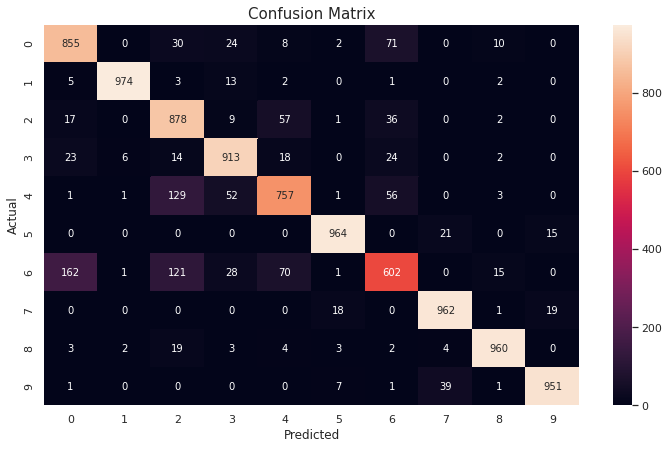

In [14]:
# if the initial run make and save predictios
if init_run:
    pred = CNN_net.predict(X_test)
    with open(root + 'CNN_pred.sav', 'wb') as fp:
        pickle.dump(pred, fp)
# else load predictions
else:
    pred = pickle.load(open(root + 'CNN_pred.sav', 'rb'))

# performance of the MLP
CNN_performance = performance(pred, y_test)

## Comparison of MLP and CNN

I'll now compare the performance of the CNN and MLP classifiers focussing in particular on the difference in the number of parameters in both models.

In aid of this I will create a plot comparing the quality measures of the models.

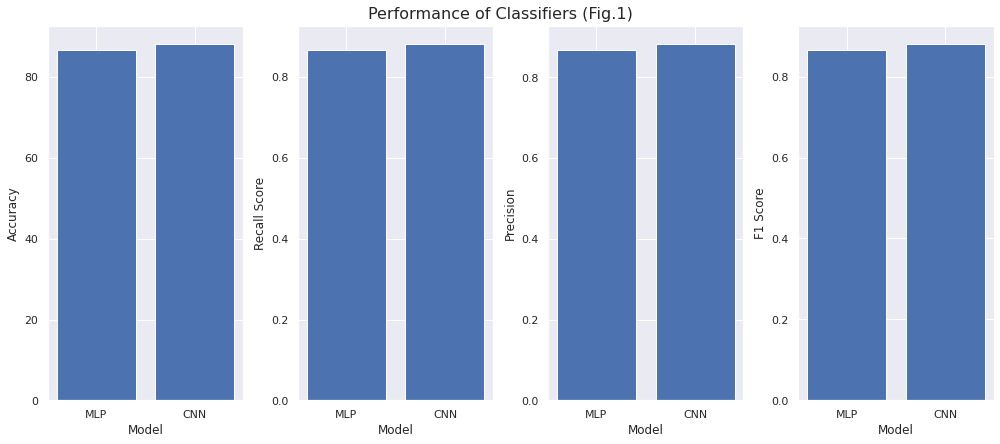

In [15]:
# create figure
fig, axs = plt.subplots(1, 4, figsize=(14, 6))

# labels
labels = ['Accuracy', 'Recall Score', 'Precision', 'F1 Score']

# creates figure title
plt.suptitle('Performance of Classifiers (Fig.1)', fontsize='16',y=1.02)

# creates plots
for i, ax in enumerate(axs):
    # get scores to plot
    scores = [MLP_performance[i], CNN_performance[i]]

    # plot
    ax.bar([0, 1], scores)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['MLP', 'CNN'])
    
    # x, y axes titles
    ax.set_ylabel(labels[i])
    ax.set_xlabel('Model')

plt.tight_layout()
plt.show()

**Computational Cost:**
*   The computational time for the MLP is a total CPU time of 43.1s.
*   The computational time for the CNN is a total CPU time of 3 min 57s.

The main reasons for the CNN being more compuationally expensive are, 


1.   A convolutionional operation is much more complex than for a linear fully connected layer with a convolution being the process of adding each element of the image to its local neighbors, weighted by the kernel. 

2.   The CNN has more layers than the MLP to 'traverse' hence increasing the number of parameters and elementary operations required to train the model.

**Accuracy:**

Both the MLP and CNN have a very similar confusion matrix with the main incorrect predictions coming for class 6 being predicted as class 0, 2, 4. Which makes sense since a shirt (class 6) looks similar to a t-shirt (class 0), pullover (class 2), coat (class 4).
Then class 4 and 2 being confused. The only difference between the confusion matrix is that the CNN makes slight less incorrect predictions.

This trend continues with the CNN slighly out-performing the MLP for all performance metrics (Fig.1) most notably in accuracy with the following accuracies respectively,

*   MLP: 86.7%
*   CNN: 88.2%

The reason CNN out performs the MLP is CNNs ability to develop an internal representation of a two-dimensional image rather than the 'vectorised' image in MLPs. This allows the model to learn position and scale in variant structures in the data, which is important when working with images. This improved ability to spot spatial relationships results in generally more accuarate predictions from CNNs than MLPs for datasets containing images. 

## Optimisation of the CNN

Now using 5-fold cross-validation on the training set, I'll optimise the CNN architecture to increase its accuracy above
90%.



---

A first step for improving the predictions is through the normalising the input data. Normalising the input data will scale the data so that the learning rate proportionally updates weights for each pixel.

In [16]:
# scaling function
scaler = StandardScaler()

# fit scaler
scaler.fit(X_train)

# transform X_train and X_valid according to this scale
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

I will now implement a dropout layer. Dropout regularisation can be used to control the fitting of a neural network to the dataset in order to reduce overfitting. 

In [17]:
class CNN(nn.Module):
  # define layers
  def __init__(self, input_size=784, num_classes=10, kernel_size=5, p=0.5):
    super(CNN,self).__init__()

    # convolutional layers
    self.conv1 = nn.Conv2d(
        in_channels=1, 
        out_channels=6, 
        kernel_size=kernel_size, 
        stride=1, 
        dilation=1)
    
    self.conv2 = nn.Conv2d(
        in_channels=6, 
        out_channels=16, 
        kernel_size=kernel_size, 
        stride=1, 
        dilation=1)
    
    # linear layers
    self.W1 = nn.Linear(16 * 4 * 4, 120)
    self.W2 = nn.Linear(120, 84)
    self.W3 = nn.Linear(84, num_classes)

    # a precusor to hidden layer which performs a dropout with rate p
    self.dropout = nn.Dropout(p=p)

  # define forward function
  def forward(self, x):
    # resizes input
    out = x.reshape(x.size(0), 1, 28, 28).float()

    # conv1
    out = F.relu(self.conv1(out))

    # subsampling 1
    out = F.max_pool2d(out, kernel_size=2, stride=2)

    # conv2
    out = F.relu(self.conv2(out))

    # subsampling 2
    out = F.max_pool2d(out, kernel_size=2, stride=2)
  
    # fc1
    out = out.view(out.size(0), -1)
    out = self.dropout(out)
    out = F.relu(self.W1(out))

    # fc2
    out = self.dropout(out)
    out = F.relu(self.W2(out))

    # fc3
    out = self.dropout(out)

    return self.W3(out)

# apply skorch wrapper to Network for use with sklearn
CNN_net = NeuralNetClassifier(
    CNN(),
    max_epochs=num_epochs,
    batch_size=batch_size,
    criterion = nn.CrossEntropyLoss,
    optimizer = SGD,
    )

Apply 5-fold cross-validation of the learning rate and drop out rate.

In [18]:
# parameters to optimise
p = np.arange(0, 0.8, 0.2)
lr = 5*10.0**(-np.arange(1,5)) 

params = {'module__p' : p,
          'optimizer__lr': lr}

if init_run:
    # grid search of parameters
    CV = GridSearchCV(CNN_net, params, scoring='accuracy', cv=StratifiedKFold(
        shuffle=True, random_state=0))
    
    # train model
    CV.fit(X_train, y_train)
    
    # save results
    with open(root + 'CV_1.sav', 'wb') as fp:
        pickle.dump(CV, fp)

else:
    # load fitted grid search
    CV = pickle.load(open(root + 'CV_1.sav', 'rb'))

# print results
print('Best Score: ', CV.best_score_, '\nBest Parameters: ', CV.best_params_)

Best Score:  0.8872 
Best Parameters:  {'module__p': 0.0, 'optimizer__lr': 0.05}


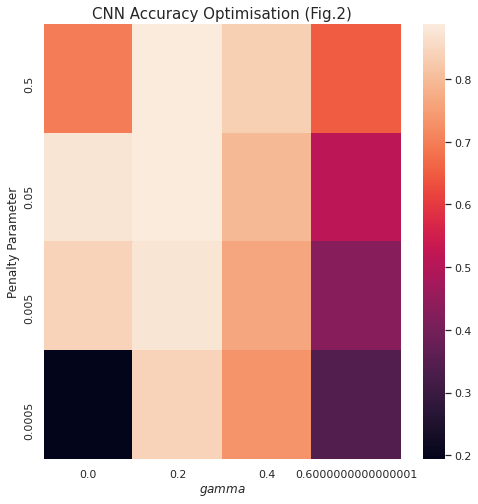

In [19]:
# create fig
fig, ax = plt.subplots(figsize = (2*len(p), 2*len(lr)))

# gets a 2D grid of results
scores = CV.cv_results_['mean_test_score']
grid = scores.reshape(len(p), len(lr))

# create heat map of CV   
sns.heatmap(grid, xticklabels=p, yticklabels=lr,
            ax=ax)
# title
ax.set_title('CNN Accuracy Optimisation (Fig.2)',
            fontsize='15', y=1.04)

ax.set_ylabel('Penalty Parameter')
ax.set_xlabel(r'$gamma$')

plt.show()

I will now implement an early stopping callback at 90% model accuracy to reduce overfitting and to reduce computational complexity. I will also increae the max number of epochs to reduce the chance of under fitting. I will finally optimise the batch size, learning rate and dropout rate.

In [20]:
class CustomCallback(Callback):
    def on_epoch_end(self, net, **kwargs):
        epoch = len(net.history)
        current_score = net.history[-1, 'valid_acc']
      
        # stop if accuracy > 90
        if current_score >= 0.9:
            print('Stopped Accuracy is %.4f >= 0.9'%current_score) 
            raise KeyboardInterrupt
        # stop if epoch > 30 
        if epoch > 20 and current_score < 0.85:
            print('Stopped Accuracy is Increasing too slowly.') 
            raise KeyboardInterrupt
        if epoch > 10 and current_score < 0.80:
            print('Stopped Accuracy is Increasing too slowly.') 
            raise KeyboardInterrupt

callback = CustomCallback()

# apply skorch wrapper to Network for use with sklearn
CNN_net = NeuralNetClassifier(
    CNN(),
    max_epochs=50,
    criterion = nn.CrossEntropyLoss,
    optimizer = SGD,
    callbacks=[callback])

In [21]:
# parameters to optimise
p = [0.1, 0.2]
lr = [0.01,0.05]
batch_size = [64 ,128, 256]

params = {'module__p' : p,
          'optimizer__lr': lr,
          'batch_size':batch_size}

if init_run:
    # grid search of parameters
    CV = GridSearchCV(CNN_net, params, scoring='accuracy', cv=StratifiedKFold(
        shuffle=True, random_state=0))
    
    # train model
    CV.fit(X_train, y_train)
    
    # save results
    with open(root + 'CV_2.sav', 'wb') as fp:
        pickle.dump(CV, fp)

else:
    # load fitted grid search
    CV = pickle.load(open(root + 'CV_2.sav', 'rb'))

# print results
print('Best Score: ', CV.best_score_, '\nBest Parameters: ', CV.best_params_)

Best Score:  0.8980333333333332 
Best Parameters:  {'batch_size': 64, 'module__p': 0.1, 'optimizer__lr': 0.05}


The model is yet to reach 90% accuracy so I will now decrease the kernel size for the convolutional layers. Swapping from large ($5 \times 5$ ) to small kernel sizes of ($3 \times 3$ and $4 \times 4$) will improve the capture of local features. Note: I will keep the current optimised parameters for the next run despite the fact they may not be optimum for this model.

In [22]:
class CNN(nn.Module):
  # define layers
  def __init__(self, input_size=784, num_classes=10, p=0.5):
    super(CNN,self).__init__()

    # convolutional layers
    self.conv1 = nn.Conv2d(
        in_channels=1, 
        out_channels=6, 
        kernel_size=3, 
        stride=1, 
        dilation=1)
    
    self.conv2 = nn.Conv2d(
        in_channels=6, 
        out_channels=16, 
        kernel_size=4, 
        stride=1, 
        dilation=1)
    
    # linear layers
    self.W1 = nn.Linear(16 * 5 * 5, 120)
    self.W2 = nn.Linear(120, 84)
    self.W3 = nn.Linear(84, num_classes)

    # a precusor to hidden layer which performs a dropout with rate p
    self.dropout = nn.Dropout(p=p)

  # define forward function
  def forward(self, x):
    # resizes input
    out = x.reshape(x.size(0), 1, 28, 28).float()

    # conv1
    out = F.relu(self.conv1(out))

    # subsampling 1
    out = F.max_pool2d(out, kernel_size=2, stride=2)

    # conv2
    out = F.relu(self.conv2(out))

    # subsampling 2
    out = F.max_pool2d(out, kernel_size=2, stride=2)
  
    # fc1
    out = out.view(out.size(0), -1)
    out = self.dropout(out)
    out = F.relu(self.W1(out))

    # fc2
    out = self.dropout(out)
    out = F.relu(self.W2(out))

    # fc3
    out = self.dropout(out)

    return self.W3(out)


# apply skorch wrapper to Network for use with sklearn
CNN_net = NeuralNetClassifier(
    CNN(),
    max_epochs=50,
    criterion = nn.CrossEntropyLoss,
    optimizer = SGD
    )

In [23]:
# parameters to optimise
params = {'module__p' : [0.1],
          'optimizer__lr': [0.05],
          'batch_size':[64]}

if init_run:
    # grid search of parameters
    CV = GridSearchCV(CNN_net, params, scoring='accuracy', cv=StratifiedKFold(
        shuffle=True, random_state=0))
    
    # train model
    CV.fit(X_train, y_train)
    
    # save results
    with open(root + 'CV_3.sav', 'wb') as fp:
        pickle.dump(CV, fp)

else:
    # load fitted grid search
    CV = pickle.load(open(root + 'CV_3.sav', 'rb'))

# print results
print('Best Score: ', CV.best_score_, '\nBest Parameters: ', CV.best_params_)

Best Score:  0.9032666666666666 
Best Parameters:  {'batch_size': 64, 'module__p': 0.1, 'optimizer__lr': 0.05}


Decreasing the kernel size has increased accuracy to above 90%.